# SDXL-controlnet: Canny
These are controlnet weights trained on stabilityai/stable-diffusion-xl-base-1.0 with canny conditioning. You can find some example images in the following.

prompt: a couple watching a romantic sunset, 4k photo

In [1]:
!pip install accelerate transformers safetensors opencv-python diffusers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.2 MB/s eta 0:00:00
  Attempting uninstall: safetensors
    Found existing installation: safetensors 0.3.1
    Uninstalling safetensors-0.3.1:
      Successfully uninstalled safetensors-0.3.1
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.19.0.dev0
    Uninstalling diffusers-0.19.0.dev0:
      Successfully uninstalled diffusers-0.19.0.dev0


In [2]:
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL
from diffusers.utils import load_image
from PIL import Image
import torch
import numpy as np
import cv2

/home/alfred/anaconda3/envs/dui/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-08-22 03:05:02,926] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [99]:
prompt = "A fashion model poses with casual summer dress with blue and yellow strips, best quality, extremely detailed"
negative_prompt = 'background, low quality, bad quality, sketches'

#image = load_image("https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/sd_controlnet/hf-logo.png")
image = load_image("image_fashion_14.jpg")

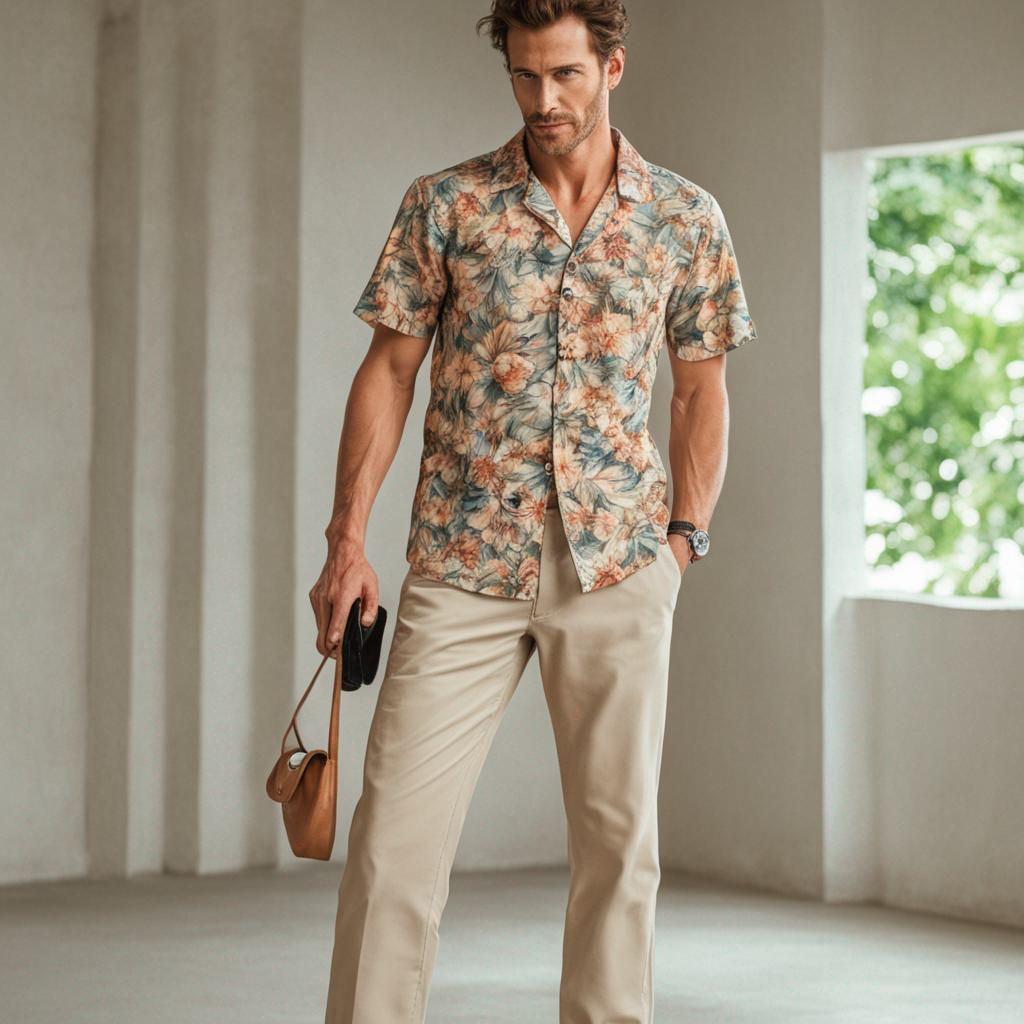

In [95]:
image.show()

In [84]:
### Edge detection

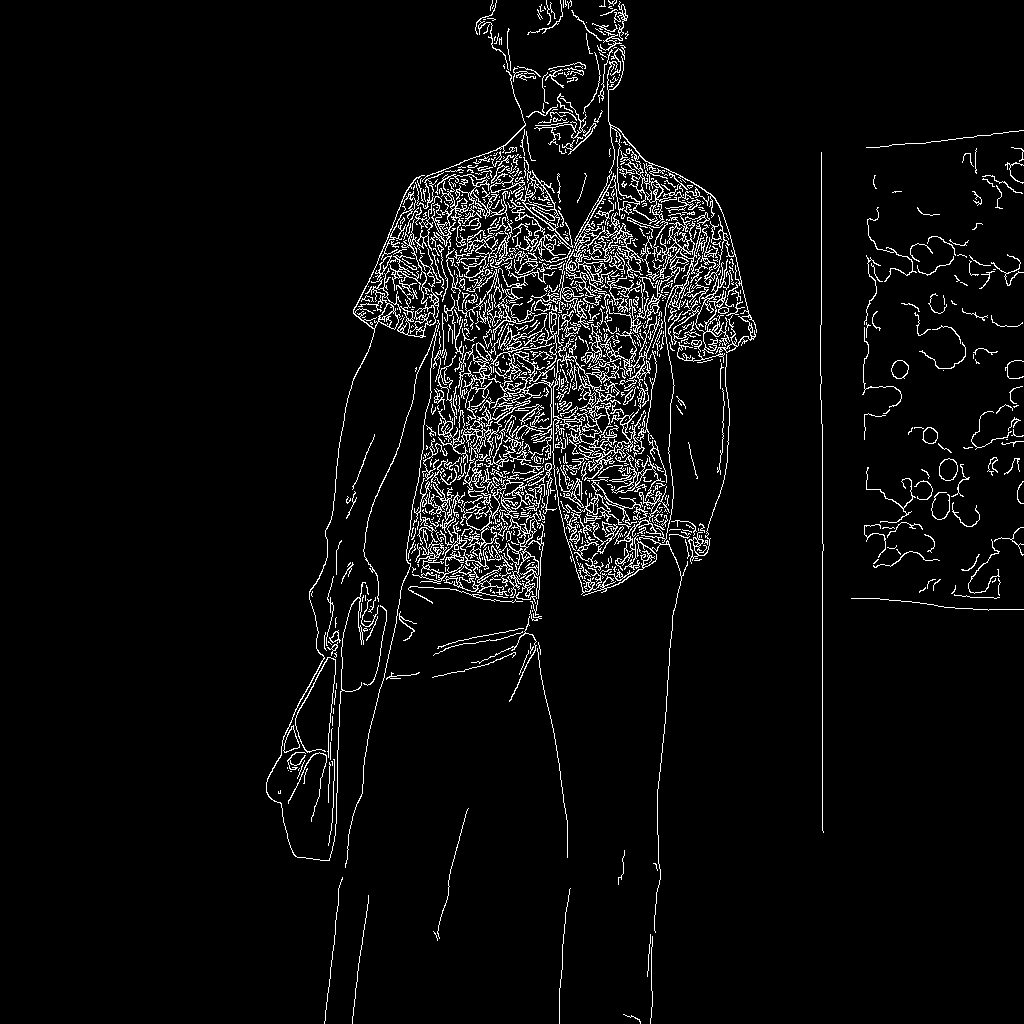

In [100]:
image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

In [86]:
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-canny-sdxl-1.0",
    torch_dtype=torch.float16
)
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    vae=vae,
    torch_dtype=torch.float16,
)
pipe.enable_model_cpu_offload()

Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:44<00:00, 14.87s/it]


In [101]:
# flush cuda cache memory
torch.cuda.empty_cache()

In [102]:
image = np.array(image)
image = cv2.Canny(image, 100, 200)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
image = Image.fromarray(image)


In [110]:
#generator = [torch.Generator(device="cuda").manual_seed(4) for i in range(len(prompt))]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:16<00:00,  2.11it/s]


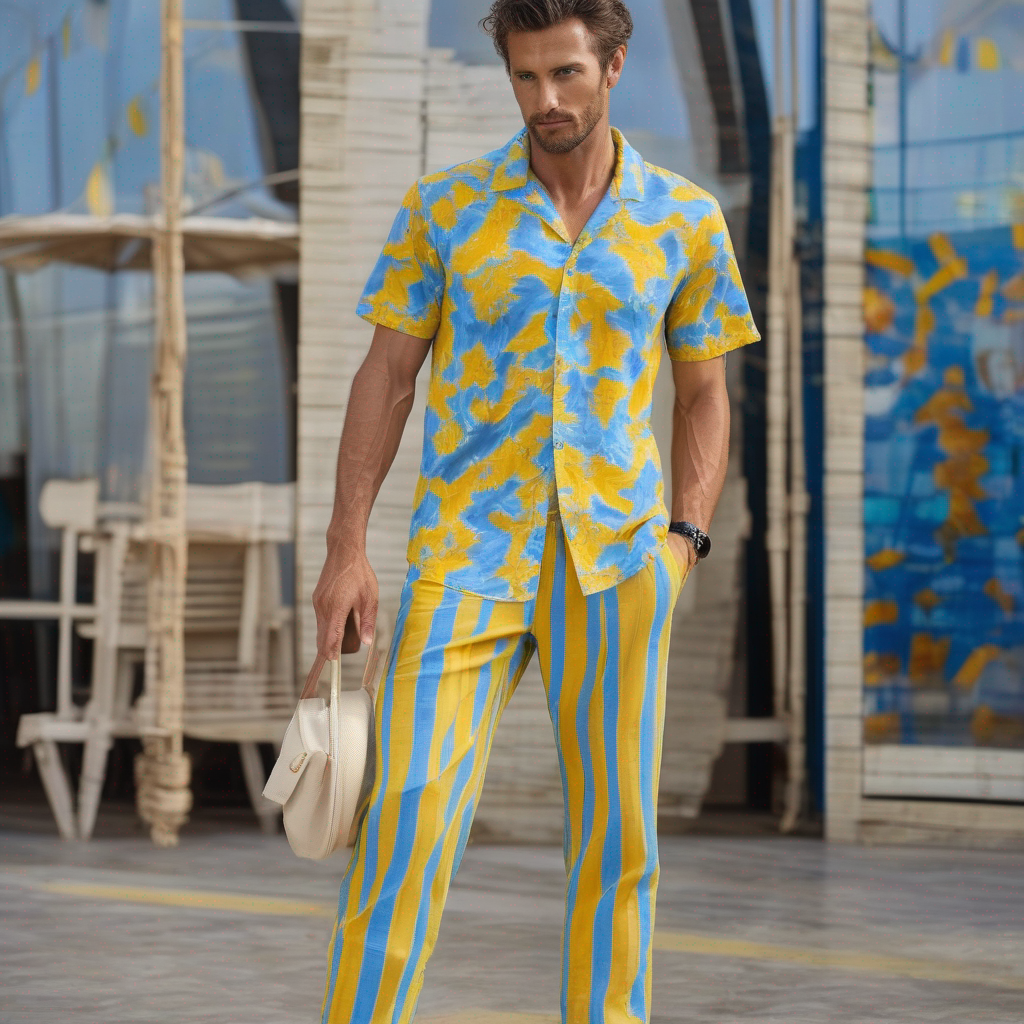

In [111]:
controlnet_conditioning_scale = 0.5  # recommended for good generalization
images = pipe(
    prompt, negative_prompt=negative_prompt, 
    image=canny_image, 
    controlnet_conditioning_scale=controlnet_conditioning_scale,
    num_inference_steps=35,
    #generator=generator,
    ).images

#images[0].save(f"hug_lab.png")
images[0].show()

In [112]:
## Let's first create a simple helper function to display images as a grid.

In [113]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [114]:
# flush cuda cache memory
torch.cuda.empty_cache()

We want to take full advantage of the amazing FlashAttention/xformers attention layer acceleration, so let's enable this! If this command does not work for you, you might not have xformers correctly installed. In this case, you can just skip the following line of code.

In [115]:
pipe.enable_xformers_memory_efficient_attention()

In [116]:
#Next, we define the input prompts and set a seed for reproducability.

prompt = [t + prompt for t in ["Sandra Oh as ", "Kim Kardashian as ", "rihanna as ", "taylor swift as "]]
negative_prompt = [t + negative_prompt for t in ["lip stick, ", "white skin, ", "long hair, ", "hat, "]]
generator = [torch.Generator(device="cuda").manual_seed(2) for i in range(len(prompt))]

In [ ]:
#Finally, we can run the pipeline and display the image!
'''
output = pipe(
    prompt,
    canny_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    num_inference_steps=20,
    generator=generator,
    controlnet_conditioning_scale=controlnet_conditioning_scale,
)
'''
output = pipe(
    prompt, 
    negative_prompt=negative_prompt, 
    image=canny_image, 
    controlnet_conditioning_scale=controlnet_conditioning_scale,
    num_inference_steps=35,
    generator = generator,
    )

image_grid(output.images, 2, 2)

  3%|█████▋                                                                                                                                                                                                | 1/35 [00:02<01:30,  2.67s/it]

## Open Pose

In [25]:
from controlnet_aux import OpenposeDetector
# Compute openpose conditioning image.
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

ModuleNotFoundError: No module named 'controlnet_aux'